# BOM Analysis Dashboard
## Acoustic Manufacturing System - Level 1 to Level 4 Analysis

This notebook provides comprehensive analysis of the Bill of Materials including:
- Full BOM by subsystem
- Cost breakdowns by component type
- Expansion path analysis with upgrade costs

In [4]:
# Install required packages if needed
import subprocess
import sys

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Check and install required packages
packages = ['pandas', 'matplotlib', 'seaborn', 'numpy', 'openpyxl']
for package in packages:
    try:
        __import__(package)
    except ImportError:
        print(f"Installing {package}...")
        install(package)

# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import numpy as np

# Import our component registry
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'models')))

from component_registry import ComponentRegistry, ComponentCategory, ComponentType
from mark_components_for_expansion import mark_expansion_components

# Set up plotting style
plt.style.use('default')
sns.set_theme()
sns.set_palette("husl")

# Initialize registry with expansion data
registry = mark_expansion_components(verbose=False)
print("Component Registry loaded with expansion data")

Installing seaborn...
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Installing openpyxl...
  Using cached openpyxl-3.1.5-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached et_xmlfile-2.0.0-py3-none-any.whl.metadata (2.7 kB)
Using cached openpyxl-3.1.5-py2.py3-none-any.whl (250 kB)
Using cached et_xmlfile-2.0.0-py3-none-any.whl (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [openpyxl]━━ 1/2 [openpyxl]
Component Registry loaded with expansion data


## 1. Full BOM by Subsystem

In [5]:
# Create comprehensive BOM dataframe
bom_data = []

for component in registry.components:
    bom_data.append({
        'Subsystem': component.category.value,
        'Component': component.name,
        'Type': component.type.value,
        'Specification': component.specification,
        'Quantity': component.quantity,
        'Unit Cost': f"${component.unit_cost:,.2f}",
        'Total Cost': f"${component.total_cost:,.2f}",
        'Material': component.material or 'N/A',
        'Supplier': component.supplier or 'TBD',
        'Notes': component.notes
    })

bom_df = pd.DataFrame(bom_data)

# Display BOM by subsystem
for subsystem in ComponentCategory:
    display(HTML(f"<h3>{subsystem.value}</h3>"))
    subsystem_df = bom_df[bom_df['Subsystem'] == subsystem.value]
    display(subsystem_df.style.set_properties(**{'text-align': 'left'}).hide(axis='index'))
    
    # Calculate subsystem totals
    subsystem_components = [c for c in registry.components if c.category == subsystem]
    cots_total = sum(c.total_cost for c in subsystem_components if c.type == ComponentType.COTS)
    custom_total = sum(c.total_cost for c in subsystem_components if c.type == ComponentType.CUSTOM)
    
    display(HTML(f"<p><b>Subsystem Totals:</b> COTS: ${cots_total:,.2f} | Custom: ${custom_total:,.2f} | Total: ${cots_total + custom_total:,.2f}</p>"))

Subsystem,Component,Type,Specification,Quantity,Unit Cost,Total Cost,Material,Supplier,Notes
Frame Subsystem,Kapton Tubes,Commercial Off-The-Shelf,"DuPont HN, 4"" dia, 0.005"" wall, 400°C",2,$90.00,$180.00,N/A,TBD,Thermal isolation barrier
Frame Subsystem,Assembly Rails,Commercial Off-The-Shelf,"1/2"" zinc threaded rod, 12"" length",4,$2.50,$10.00,N/A,TBD,For mounting acoustic rings
Frame Subsystem,Frame,Custom Fabricated,"Steel weldment, powder coated",1,$800.00,$800.00,Steel,TBD,Main structural support
Frame Subsystem,Baseplate,Custom Fabricated,"1/2"" aluminum, machined",1,$400.00,$400.00,Aluminum,TBD,Precision mounting surface
Frame Subsystem,SS Tube,Custom Fabricated,"316 SS, 120mm ID × 150mm",1,$350.00,$350.00,316 Stainless Steel,TBD,Chamber cylinder
Frame Subsystem,Top Plate,Custom Fabricated,"1/4"" aluminum, machined",1,$250.00,$250.00,Aluminum,TBD,Chamber top with ports
Frame Subsystem,Access Panel,Custom Fabricated,Acrylic/polycarbonate window,1,$150.00,$150.00,Acrylic/Polycarbonate,TBD,Observation window
Frame Subsystem,Build Volume,Custom Fabricated,Insulated chamber assembly,1,$600.00,$600.00,N/A,TBD,Includes seals
Frame Subsystem,Thermal Isolation Layer,Custom Fabricated,Ceramic fiber composite,1,$200.00,$200.00,Ceramic fiber composite,TBD,High-temp insulation
Frame Subsystem,Air/Gas Border,Custom Fabricated,Silicone/Viton seals,1,$100.00,$100.00,Silicone/Viton,TBD,Chamber sealing


Subsystem,Component,Type,Specification,Quantity,Unit Cost,Total Cost,Material,Supplier,Notes
Heated Bed Subsystem,Heating Rods,Commercial Off-The-Shelf,"1kW cartridge, 12mm×150mm, 220V",4,$25.00,$100.00,N/A,TBD,Platform heating
Heated Bed Subsystem,Thermocouples,Commercial Off-The-Shelf,"Type K, M6 thread, 800°C",2,$12.00,$24.00,N/A,TBD,Bed temperature sensing
Heated Bed Subsystem,Heated Bed Assembly,Custom Fabricated,Aluminum block with channels,1,$450.00,$450.00,Aluminum,TBD,Includes mounting
Heated Bed Subsystem,Conductive Block,Custom Fabricated,Copper/aluminum composite,1,$300.00,$300.00,Copper/Aluminum composite,TBD,Heat distribution
Heated Bed Subsystem,Distribution Channels,Custom Fabricated,CNC machined pathways,1,$200.00,$200.00,N/A,TBD,Integrated in bed
Heated Bed Subsystem,Thermal Isolation Tube,Custom Fabricated,Multi-layer insulation,1,$350.00,$350.00,N/A,TBD,"Includes air gaps, thermal breaks"


Subsystem,Component,Type,Specification,Quantity,Unit Cost,Total Cost,Material,Supplier,Notes
Acoustic Cylinder Subsystem,40kHz Transducers,Commercial Off-The-Shelf,"16mm ultrasonic, waterproof",18,$2.00,$36.00,N/A,TBD,6 per ring × 3 rings
Acoustic Cylinder Subsystem,Cable Ties,Commercial Off-The-Shelf,"8"" nylon, standard temp",18,$0.22,$4.00,N/A,Harbor Freight,Harbor Freight 100-pack
Acoustic Cylinder Subsystem,Acoustic Cylinder,Custom Fabricated,"Aluminum tube, machined",1,$600.00,$600.00,Aluminum,TBD,Precision bore for waves
Acoustic Cylinder Subsystem,Transducer Array Layer,Custom Fabricated,Custom PCB with mounting,1,$400.00,$400.00,N/A,TBD,Includes connectors
Acoustic Cylinder Subsystem,Transducer Rings,Custom Fabricated,"Aluminum, CNC machined",3,$150.00,$450.00,Aluminum,TBD,$450 total
Acoustic Cylinder Subsystem,Transducer Housing,Custom Fabricated,3D printed or machined,6,$50.00,$300.00,N/A,TBD,$300 total
Acoustic Cylinder Subsystem,Cooling Channels,Custom Fabricated,Integrated water passages,1,$200.00,$200.00,N/A,TBD,Built into housing
Acoustic Cylinder Subsystem,Cooling Layer,Custom Fabricated,Heat sink assembly,1,$250.00,$250.00,N/A,TBD,With fins
Acoustic Cylinder Subsystem,Air/Water Jacket,Custom Fabricated,Welded aluminum,1,$300.00,$300.00,Aluminum,TBD,Cooling manifold


Subsystem,Component,Type,Specification,Quantity,Unit Cost,Total Cost,Material,Supplier,Notes
Crucible Subsystem,Induction Heater,Commercial Off-The-Shelf,"DaWei 15kW, 30-80kHz",1,$700.00,$700.00,N/A,DaWei,Run at 3kW for L1
Crucible Subsystem,Pellet Hopper,Commercial Off-The-Shelf,3D printed PLA + hardware,1,$20.00,$20.00,N/A,TBD,Includes stepper motor
Crucible Subsystem,Feedrate Controller,Commercial Off-The-Shelf,"TB6600 stepper driver, 4A",1,$25.00,$25.00,N/A,TBD,Single axis control
Crucible Subsystem,Temperature Controller,Commercial Off-The-Shelf,REX-C100 PID clone,1,$15.00,$15.00,N/A,TBD,SSR output for induction
Crucible Subsystem,Thermocouples,Commercial Off-The-Shelf,"Type K, ceramic sheath",2,$12.00,$24.00,N/A,TBD,Crucible monitoring
Crucible Subsystem,Micro Heaters,Commercial Off-The-Shelf,"12V 40W cartridge, 6mm×20mm",25,$8.00,$200.00,N/A,TBD,Feed line heating
Crucible Subsystem,Crucible Assembly,Custom Fabricated,Graphite + insulation,1,$400.00,$400.00,Graphite,TBD,Complete unit
Crucible Subsystem,Material Feed System,Custom Fabricated,Machined aluminum,1,$350.00,$350.00,Aluminum,TBD,Includes guides
Crucible Subsystem,Induction Coil Assembly,Custom Fabricated,Copper tube + mounting,1,$250.00,$250.00,Copper,TBD,Custom wound
Crucible Subsystem,Material Delivery System,Custom Fabricated,Multi-channel manifold,1,$400.00,$400.00,N/A,TBD,25 outlets


Subsystem,Component,Type,Specification,Quantity,Unit Cost,Total Cost,Material,Supplier,Notes
Power/Control Subsystem,10kW PSU,Commercial Off-The-Shelf,Mean Well RSP-10000-48,1,"$1,850.00","$1,850.00",N/A,Mean Well,Main power supply
Power/Control Subsystem,FPGA Board,Commercial Off-The-Shelf,Cyclone IV EP4CE6,1,$75.00,$75.00,N/A,TBD,Per VDATP reference
Power/Control Subsystem,6-Channel Amp Modules,Commercial Off-The-Shelf,TDA2030 DIY boards,4,$15.00,$60.00,N/A,TBD,Build from kits
Power/Control Subsystem,8-Channel Relays,Commercial Off-The-Shelf,"Generic relay modules, 10A",5,$8.00,$40.00,N/A,eBay/AliExpress,eBay/AliExpress
Power/Control Subsystem,STM32 Dev Board,Commercial Off-The-Shelf,STM32F4 Discovery,1,$25.00,$25.00,N/A,TBD,Real STM32 for development
Power/Control Subsystem,Industrial PC,Commercial Off-The-Shelf,User-provided,0,$0.00,$0.00,N/A,TBD,"Min specs: i5, 8GB RAM"
Power/Control Subsystem,Control Bus PCB,Custom Fabricated,4-layer board,1,$350.00,$350.00,N/A,TBD,Main interconnect
Power/Control Subsystem,Acoustic Bus PCB,Custom Fabricated,2-layer board,1,$200.00,$200.00,N/A,TBD,Transducer routing
Power/Control Subsystem,Thermal Bus PCB,Custom Fabricated,2-layer board with relays,1,$250.00,$250.00,N/A,TBD,Heater control
Power/Control Subsystem,Wiring Harness,Custom Fabricated,Custom cables,1,$300.00,$300.00,N/A,TBD,All interconnects


## 2. Cost Breakdown Analysis

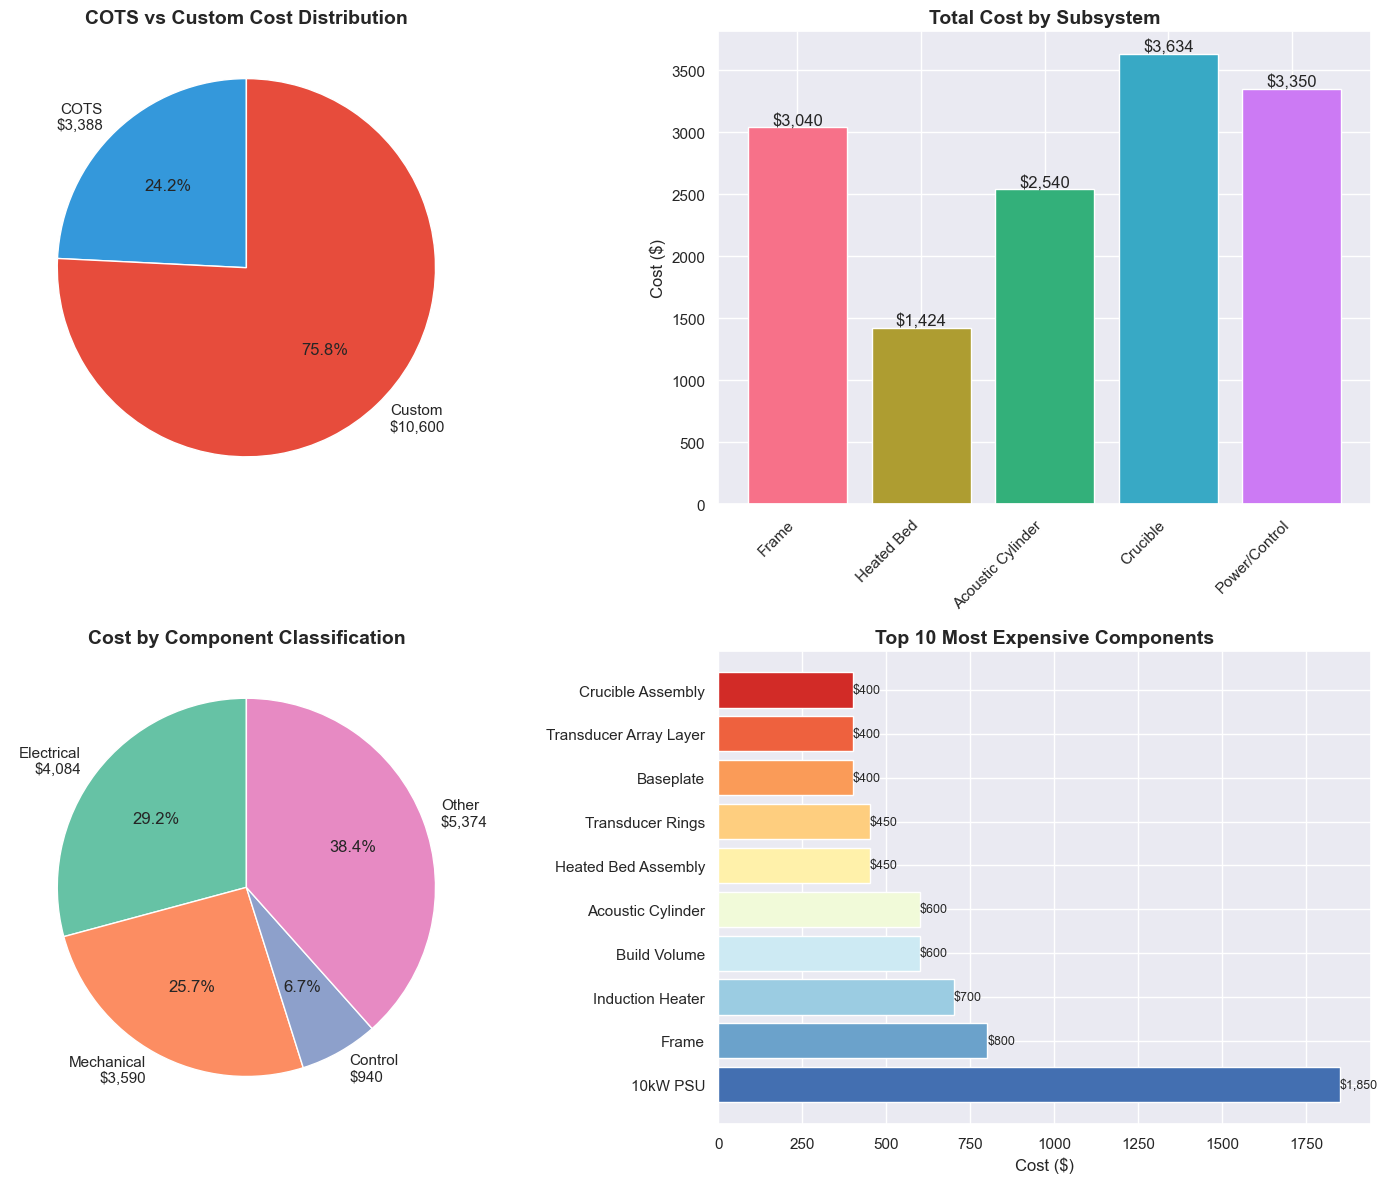


COST SUMMARY STATISTICS
Total System Cost: $13,988.00
COTS Components: $3,388.00 (24.2%)
Custom Components: $10,600.00 (75.8%)
Average Component Cost: $274.27
Most Expensive Component: 10kW PSU ($1,850.00)


In [6]:
# Create cost breakdown visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 2.1 COTS vs Custom breakdown
ax1 = axes[0, 0]
type_totals = registry.get_grand_totals()
type_data = [type_totals['COTS'], type_totals['Custom']]
type_labels = ['COTS', 'Custom']
colors = ['#3498db', '#e74c3c']

wedges, texts, autotexts = ax1.pie(type_data, labels=type_labels, autopct='%1.1f%%', 
                                    colors=colors, startangle=90)
ax1.set_title('COTS vs Custom Cost Distribution', fontsize=14, weight='bold')

# Add total amounts to labels
for i, (label, value) in enumerate(zip(type_labels, type_data)):
    texts[i].set_text(f"{label}\n${value:,.0f}")

# 2.2 Cost by Subsystem
ax2 = axes[0, 1]
subsystem_costs = registry.get_total_cost_by_category()
subsystems = [cat.value for cat in ComponentCategory]
subsystem_totals = [subsystem_costs[cat]['Total'] for cat in ComponentCategory]

bars = ax2.bar(range(len(subsystems)), subsystem_totals, color=sns.color_palette("husl", len(subsystems)))
ax2.set_xticks(range(len(subsystems)))
ax2.set_xticklabels([s.replace(' Subsystem', '') for s in subsystems], rotation=45, ha='right')
ax2.set_ylabel('Cost ($)', fontsize=12)
ax2.set_title('Total Cost by Subsystem', fontsize=14, weight='bold')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'${height:,.0f}', ha='center', va='bottom')

# 2.3 Component Classification (Electrical/Mechanical/Control)
ax3 = axes[1, 0]

# Classify components
electrical_keywords = ['Heater', 'Thermocouple', 'PSU', 'Transducer', 'Amp', 'Relay', 'FPGA', 'STM32', 'Controller']
mechanical_keywords = ['Frame', 'Tube', 'Plate', 'Block', 'Ring', 'Housing', 'Cylinder', 'Rails', 'Panel', 'Crucible']
control_keywords = ['FPGA', 'STM32', 'Controller', 'Bus', 'PCB']

classification = {'Electrical': 0, 'Mechanical': 0, 'Control': 0, 'Other': 0}

for component in registry.components:
    name = component.name
    if any(keyword in name for keyword in control_keywords):
        classification['Control'] += component.total_cost
    elif any(keyword in name for keyword in electrical_keywords):
        classification['Electrical'] += component.total_cost
    elif any(keyword in name for keyword in mechanical_keywords):
        classification['Mechanical'] += component.total_cost
    else:
        classification['Other'] += component.total_cost

class_labels = list(classification.keys())
class_values = list(classification.values())

wedges, texts, autotexts = ax3.pie(class_values, labels=class_labels, autopct='%1.1f%%',
                                    startangle=90, colors=sns.color_palette("Set2", len(class_labels)))
ax3.set_title('Cost by Component Classification', fontsize=14, weight='bold')

# Add amounts to labels
for i, (label, value) in enumerate(zip(class_labels, class_values)):
    texts[i].set_text(f"{label}\n${value:,.0f}")

# 2.4 Top 10 Most Expensive Components
ax4 = axes[1, 1]
sorted_components = sorted(registry.components, key=lambda x: x.total_cost, reverse=True)[:10]
comp_names = [c.name for c in sorted_components]
comp_costs = [c.total_cost for c in sorted_components]

bars = ax4.barh(range(len(comp_names)), comp_costs, color=sns.color_palette("RdYlBu_r", len(comp_names)))
ax4.set_yticks(range(len(comp_names)))
ax4.set_yticklabels(comp_names)
ax4.set_xlabel('Cost ($)', fontsize=12)
ax4.set_title('Top 10 Most Expensive Components', fontsize=14, weight='bold')

# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax4.text(width, bar.get_y() + bar.get_height()/2.,
            f'${width:,.0f}', ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.show()

# Summary statistics
print("\nCOST SUMMARY STATISTICS")
print("=" * 50)
print(f"Total System Cost: ${type_totals['Total']:,.2f}")
print(f"COTS Components: ${type_totals['COTS']:,.2f} ({type_totals['COTS']/type_totals['Total']*100:.1f}%)")
print(f"Custom Components: ${type_totals['Custom']:,.2f} ({type_totals['Custom']/type_totals['Total']*100:.1f}%)")
print(f"Average Component Cost: ${type_totals['Total']/len(registry.components):,.2f}")
print(f"Most Expensive Component: {sorted_components[0].name} (${sorted_components[0].total_cost:,.2f})")

## 3. Expansion BOM Analysis

In [7]:
# Create expansion analysis
expansion_data = []
level_costs = {'L1': 0, 'L2': 0, 'L3': 0, 'L4': 0}

# Parse expansion notes to extract costs
import re

for component in registry.get_components_requiring_expansion():
    # Extract upgrade costs from expansion notes
    notes = component.expansion_notes
    
    # Parse L2, L3, L4 costs
    l2_match = re.search(r'L2:.*?\(\+\$([0-9,]+)\)', notes)
    l3_match = re.search(r'L3:.*?\(\+\$([0-9,]+)\)', notes)
    l4_match = re.search(r'L4:.*?\(\+\$([0-9,]+)\)', notes)
    
    l2_cost = int(l2_match.group(1).replace(',', '')) if l2_match else 0
    l3_cost = int(l3_match.group(1).replace(',', '')) if l3_match else 0
    l4_cost = int(l4_match.group(1).replace(',', '')) if l4_match else 0
    
    # Handle special cases where L3 is "same as L2"
    if 'L3: Same as L2' in notes:
        l3_cost = 0
    
    expansion_data.append({
        'Component': component.name,
        'Subsystem': component.category.value,
        'L1 Cost': component.total_cost,
        'L2 Upgrade': l2_cost,
        'L3 Upgrade': l3_cost,
        'L4 Upgrade': l4_cost,
        'Total L4 Cost': component.total_cost + l2_cost + l3_cost + l4_cost,
        'Expansion Notes': notes
    })
    
    level_costs['L1'] += component.total_cost
    level_costs['L2'] += l2_cost
    level_costs['L3'] += l3_cost
    level_costs['L4'] += l4_cost

expansion_df = pd.DataFrame(expansion_data)

# Display expansion table
display(HTML("<h3>Components Requiring Expansion</h3>"))
display(expansion_df[['Component', 'Subsystem', 'L1 Cost', 'L2 Upgrade', 'L3 Upgrade', 'L4 Upgrade', 'Total L4 Cost']].style
        .format({
            'L1 Cost': '${:,.0f}',
            'L2 Upgrade': '+${:,.0f}',
            'L3 Upgrade': '+${:,.0f}',
            'L4 Upgrade': '+${:,.0f}',
            'Total L4 Cost': '${:,.0f}'
        })
        .set_properties(**{'text-align': 'right'})
        .set_properties(subset=['Component', 'Subsystem'], **{'text-align': 'left'})
        .hide(axis='index'))

Component,Subsystem,L1 Cost,L2 Upgrade,L3 Upgrade,L4 Upgrade,Total L4 Cost
SS Tube,Frame Subsystem,$350,+$200,+$0,"+$3,000","$3,550"
Build Volume,Frame Subsystem,$600,+$600,+$0,"+$3,000","$4,200"
Thermal Isolation Layer,Frame Subsystem,$200,+$400,+$0,"+$2,000","$2,600"
Air/Gas Border,Frame Subsystem,$100,+$300,+$200,+$500,"$1,100"
Heating Rods,Heated Bed Subsystem,$100,+$50,+$0,+$300,$450
Thermocouples,Heated Bed Subsystem,$24,+$24,+$24,+$24,$96
Conductive Block,Heated Bed Subsystem,$300,+$200,+$300,"+$1,000","$1,800"
40kHz Transducers,Acoustic Cylinder Subsystem,$36,+$36,+$72,+$72,$216
Transducer Rings,Acoustic Cylinder Subsystem,$450,+$450,"+$1,800","+$1,800","$4,500"
Air/Water Jacket,Acoustic Cylinder Subsystem,$300,+$800,+$0,"+$2,000","$3,100"


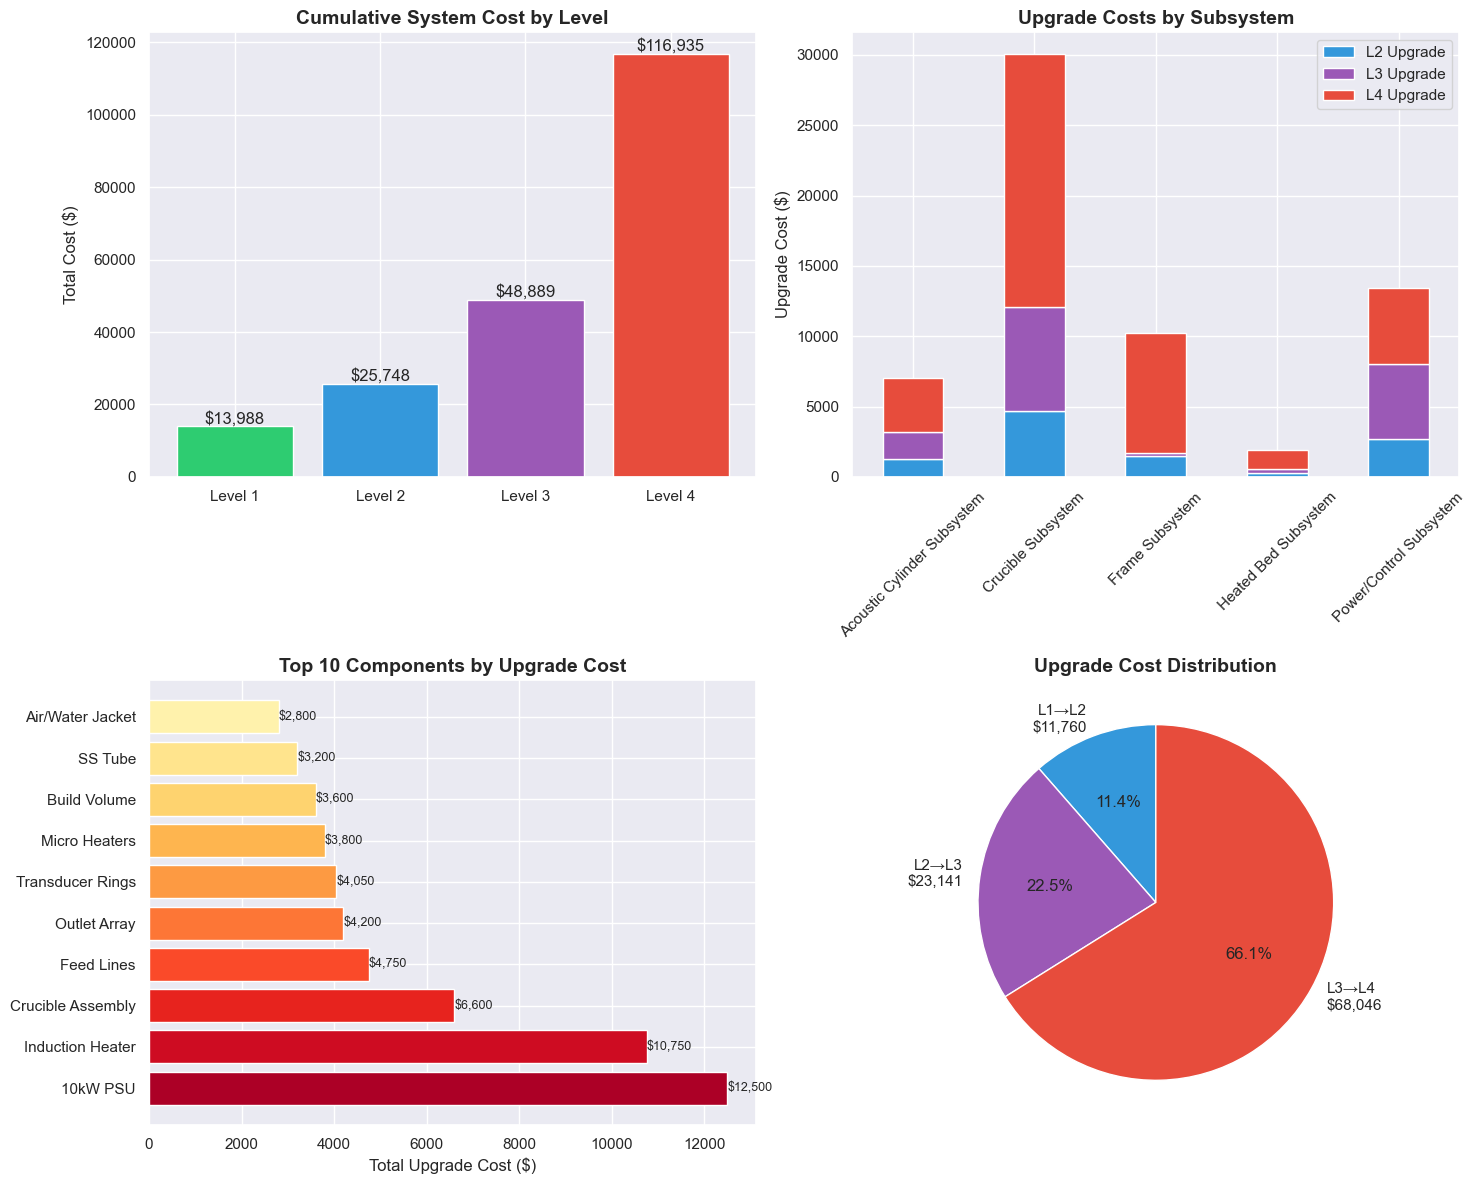

In [8]:
# Expansion cost visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 3.1 Cumulative cost by level
ax1 = axes[0, 0]

# Calculate cumulative costs including additional items
base_l1 = registry.get_grand_totals()['Total']
additional_costs = {
    'L2': 1300,  # Argon purge + windows
    'L3': 8000,  # Thermal cameras
    'L4': 31000  # Full atmosphere + software + door + filtration + camera upgrade
}

cumulative_costs = [
    base_l1,
    base_l1 + sum(expansion_df['L2 Upgrade']) + additional_costs['L2'],
    base_l1 + sum(expansion_df['L2 Upgrade']) + sum(expansion_df['L3 Upgrade']) + additional_costs['L2'] + additional_costs['L3'],
    base_l1 + sum(expansion_df['L2 Upgrade']) + sum(expansion_df['L3 Upgrade']) + sum(expansion_df['L4 Upgrade']) + 
    additional_costs['L2'] + additional_costs['L3'] + additional_costs['L4']
]

levels = ['Level 1', 'Level 2', 'Level 3', 'Level 4']
bars = ax1.bar(levels, cumulative_costs, color=['#2ecc71', '#3498db', '#9b59b6', '#e74c3c'])
ax1.set_ylabel('Total Cost ($)', fontsize=12)
ax1.set_title('Cumulative System Cost by Level', fontsize=14, weight='bold')

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'${height:,.0f}', ha='center', va='bottom')

# 3.2 Upgrade cost breakdown by subsystem
ax2 = axes[0, 1]

subsystem_upgrades = expansion_df.groupby('Subsystem')[['L2 Upgrade', 'L3 Upgrade', 'L4 Upgrade']].sum()
subsystem_upgrades.plot(kind='bar', ax=ax2, stacked=True, 
                        color=['#3498db', '#9b59b6', '#e74c3c'],
                        rot=45)
ax2.set_xlabel('')
ax2.set_ylabel('Upgrade Cost ($)', fontsize=12)
ax2.set_title('Upgrade Costs by Subsystem', fontsize=14, weight='bold')
ax2.legend(['L2 Upgrade', 'L3 Upgrade', 'L4 Upgrade'], loc='upper right')

# 3.3 Components with highest upgrade costs
ax3 = axes[1, 0]

expansion_df['Total Upgrades'] = expansion_df['L2 Upgrade'] + expansion_df['L3 Upgrade'] + expansion_df['L4 Upgrade']
top_upgrades = expansion_df.nlargest(10, 'Total Upgrades')

bars = ax3.barh(range(len(top_upgrades)), top_upgrades['Total Upgrades'], 
                color=sns.color_palette("YlOrRd_r", len(top_upgrades)))
ax3.set_yticks(range(len(top_upgrades)))
ax3.set_yticklabels(top_upgrades['Component'])
ax3.set_xlabel('Total Upgrade Cost ($)', fontsize=12)
ax3.set_title('Top 10 Components by Upgrade Cost', fontsize=14, weight='bold')

# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax3.text(width, bar.get_y() + bar.get_height()/2.,
            f'${width:,.0f}', ha='left', va='center', fontsize=9)

# 3.4 Level comparison pie chart
ax4 = axes[1, 1]

level_upgrade_costs = [
    sum(expansion_df['L2 Upgrade']) + additional_costs['L2'],
    sum(expansion_df['L3 Upgrade']) + additional_costs['L3'],
    sum(expansion_df['L4 Upgrade']) + additional_costs['L4']
]
level_labels = ['L1→L2', 'L2→L3', 'L3→L4']

wedges, texts, autotexts = ax4.pie(level_upgrade_costs, labels=level_labels, autopct='%1.1f%%',
                                    startangle=90, colors=['#3498db', '#9b59b6', '#e74c3c'])
ax4.set_title('Upgrade Cost Distribution', fontsize=14, weight='bold')

# Add amounts to labels
for i, (label, value) in enumerate(zip(level_labels, level_upgrade_costs)):
    texts[i].set_text(f"{label}\n${value:,.0f}")

plt.tight_layout()
plt.show()

In [9]:
# Detailed expansion summary
print("\nEXPANSION COST SUMMARY")
print("=" * 80)
print(f"Level 1 Base Cost: ${base_l1:,.2f}")
print(f"\nUpgrade Costs:")
print(f"  L1 → L2: ${sum(expansion_df['L2 Upgrade']) + additional_costs['L2']:,.2f}")
print(f"    Component upgrades: ${sum(expansion_df['L2 Upgrade']):,.2f}")
print(f"    Additional systems: ${additional_costs['L2']:,.2f} (Argon purge, high-temp windows)")
print(f"\n  L2 → L3: ${sum(expansion_df['L3 Upgrade']) + additional_costs['L3']:,.2f}")
print(f"    Component upgrades: ${sum(expansion_df['L3 Upgrade']):,.2f}")
print(f"    Additional systems: ${additional_costs['L3']:,.2f} (Thermal cameras)")
print(f"\n  L3 → L4: ${sum(expansion_df['L4 Upgrade']) + additional_costs['L4']:,.2f}")
print(f"    Component upgrades: ${sum(expansion_df['L4 Upgrade']):,.2f}")
print(f"    Additional systems: ${additional_costs['L4']:,.2f} (Atmosphere, software, automation)")

print(f"\nTotal Level Costs:")
for i, (level, cost) in enumerate(zip(levels, cumulative_costs)):
    if i > 0:
        increase = (cost - cumulative_costs[i-1]) / cumulative_costs[i-1] * 100
        print(f"  {level}: ${cost:,.2f} (+{increase:.1f}% from previous level)")
    else:
        print(f"  {level}: ${cost:,.2f}")

print(f"\nKey Insights:")
print(f"  - Total L1 to L4 expansion cost: ${cumulative_costs[-1] - cumulative_costs[0]:,.2f}")
print(f"  - L4 system is {cumulative_costs[-1] / cumulative_costs[0]:.1f}x the cost of L1")
print(f"  - Largest single upgrade: Induction Heater system (${2150+3000+5600:,.2f} total)")
print(f"  - Most upgraded subsystem: {subsystem_upgrades.sum(axis=1).idxmax()}")


EXPANSION COST SUMMARY
Level 1 Base Cost: $13,988.00

Upgrade Costs:
  L1 → L2: $11,760.00
    Component upgrades: $10,460.00
    Additional systems: $1,300.00 (Argon purge, high-temp windows)

  L2 → L3: $23,141.00
    Component upgrades: $15,141.00
    Additional systems: $8,000.00 (Thermal cameras)

  L3 → L4: $68,046.00
    Component upgrades: $37,046.00
    Additional systems: $31,000.00 (Atmosphere, software, automation)

Total Level Costs:
  Level 1: $13,988.00
  Level 2: $25,748.00 (+84.1% from previous level)
  Level 3: $48,889.00 (+89.9% from previous level)
  Level 4: $116,935.00 (+139.2% from previous level)

Key Insights:
  - Total L1 to L4 expansion cost: $102,947.00
  - L4 system is 8.4x the cost of L1
  - Largest single upgrade: Induction Heater system ($10,750.00 total)
  - Most upgraded subsystem: Crucible Subsystem


## 4. Export Options

In [10]:
# Export to Excel
with pd.ExcelWriter('../reports/bom_analysis_report.xlsx', engine='openpyxl') as writer:
    # Full BOM
    bom_df.to_excel(writer, sheet_name='Full BOM', index=False)
    
    # Expansion analysis
    expansion_df.to_excel(writer, sheet_name='Expansion Analysis', index=False)
    
    # Cost summary
    summary_data = {
        'Metric': ['Total L1 Cost', 'COTS Cost', 'Custom Cost', 'L2 Total', 'L3 Total', 'L4 Total'],
        'Value': [base_l1, type_totals['COTS'], type_totals['Custom']] + cumulative_costs[1:]
    }
    summary_df = pd.DataFrame(summary_data)
    summary_df.to_excel(writer, sheet_name='Cost Summary', index=False)
    
print("BOM analysis exported to: ../reports/bom_analysis_report.xlsx")

# Generate expansion notes text file
with open('../reports/expansion_notes.txt', 'w') as f:
    f.write("COMPONENT EXPANSION NOTES\n")
    f.write("=" * 80 + "\n\n")
    
    for component in registry.get_components_requiring_expansion():
        f.write(f"Component: {component.name}\n")
        f.write(f"Current Spec: {component.specification}\n")
        f.write(f"Expansion Path: {component.expansion_notes}\n")
        f.write("-" * 40 + "\n")

print("Expansion notes exported to: ../reports/expansion_notes.txt")

BOM analysis exported to: ../reports/bom_analysis_report.xlsx
Expansion notes exported to: ../reports/expansion_notes.txt


In [ ]:
# Power and Technical Analysis with Real TechnicalSpecs
print("\nPOWER BUDGET AND THERMAL ANALYSIS")
print("=" * 80)

# Verify TechnicalSpecs are present
sample_comp = registry.components[0]
if hasattr(sample_comp, 'tech_specs'):
    print(f"✅ TechnicalSpecs loaded for all {len(registry.components)} components")
    
    # Power budget analysis using built-in method
    power_budget = registry.calculate_power_budget()
    total_power = power_budget['TOTAL']['active_power']
    
    print(f"\n🔌 POWER BUDGET:")
    for subsystem, data in power_budget.items():
        if data['active_power'] > 0:
            print(f"  {subsystem:35} {data['active_power']:>8.0f}W ({data['component_count']:2} components)")
    
    print(f"\n  {'SYSTEM TOTAL':35} {total_power:>8.0f}W")
    print(f"  {'L1 POWER BUDGET':35} {12000:>8.0f}W")
    print(f"  {'MARGIN':35} {12000-total_power:>8.0f}W ({(12000-total_power)/12000*100:.1f}%)")
    
    # Thermal validation using built-in method
    thermal_validation = registry.validate_thermal_design()
    print(f"\n🌡️ THERMAL ANALYSIS:")
    print(f"  Total Heat Generation: {thermal_validation['total_heat_generation']:.0f}W")
    
    if thermal_validation['cooling_requirements']:
        print(f"  Cooling Requirements:")
        for cooling_type, data in thermal_validation['cooling_requirements'].items():
            if data['total_heat_load'] > 0:
                print(f"    - {cooling_type.title()}: {data['component_count']} components, {data['total_heat_load']:.0f}W")
    
    if thermal_validation['warnings']:
        print(f"  ⚠️ Warnings:")
        for warning in thermal_validation['warnings']:
            print(f"    • {warning}")
    
    if thermal_validation['recommendations']:
        print(f"  💡 Recommendations:")
        for rec in thermal_validation['recommendations']:
            print(f"    • {rec}")
    
    # Weight analysis
    total_weight = sum(c.tech_specs.weight * c.quantity for c in registry.components 
                      if c.tech_specs.weight)
    print(f"\n⚖️ WEIGHT ANALYSIS:")
    print(f"  Total System Weight: {total_weight:.1f} kg ({total_weight*2.2:.0f} lbs)")
    
    # Performance metrics
    power_density = total_power / total_weight if total_weight > 0 else 0
    cost_per_watt = type_totals['Total'] / total_power if total_power > 0 else 0
    
    print(f"\n📊 PERFORMANCE METRICS:")
    print(f"  Power Density: {power_density:.1f} W/kg")
    print(f"  Cost per Watt: ${cost_per_watt:.2f}/W")
    print(f"  Cost per kg: ${type_totals['Total']/total_weight:.0f}/kg")
    
else:
    print("⚠️ TechnicalSpecs not found - using basic component data only")
    print("Note: Enhanced analysis requires TechnicalSpecs in component_registry.py")